In [1]:
import pandas as pd
import numpy as np
import eurostat
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# Konfiguracja wizualna
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14

print("✅ Biblioteki załadowane. Środowisko gotowe.")

✅ Biblioteki załadowane. Środowisko gotowe.


In [2]:
def get_eurostat_series(code, filters, name):
    """
    Pobiera, czyści i formatuje pojedynczy szereg czasowy z Eurostatu.
    """
    print(f"📡 Pobieram: {name} ({code})...")
    try:
        df = eurostat.get_data_df(code)
        
        # 1. Standaryzacja nazw kolumn
        df.columns = [c.lower().strip() for c in df.columns]
        
        # 2. Aplikujemy filtry
        for col, val in filters.items():
            # Szukamy kolumny nawet jak ma dziwną nazwę (np. geo\time)
            target_col = [c for c in df.columns if col in c]
            if target_col:
                df = df[df[target_col[0]] == val]
        
        # 3. Melt (Obracanie tabeli)
        date_cols = [c for c in df.columns if c.strip().startswith(('19', '20'))]
        id_vars = [c for c in df.columns if c not in date_cols]
        df_melt = df.melt(id_vars=id_vars, value_vars=date_cols, value_name=name)
        
        # 4. Formatowanie daty i wartości
        df_melt['date'] = pd.to_datetime(df_melt['variable'], format='%Y-%m', errors='coerce')
        df_final = df_melt.set_index('date')[[name]].sort_index().dropna()
        df_final[name] = pd.to_numeric(df_final[name], errors='coerce')
        
        print(f"   ✅ Sukces: {len(df_final)} obs. (Średnia: {df_final[name].mean():.2f})")
        return df_final

    except Exception as e:
        print(f"   ❌ Błąd przy pobieraniu {name}: {e}")
        return pd.DataFrame()

📡 Pobieram: HICP (prc_hicp_manr)...
   ✅ Sukces: 348 obs. (Średnia: 4.56)
📡 Pobieram: Unemployment (une_rt_m)...
   ✅ Sukces: 310 obs. (Średnia: 8.46)
📡 Pobieram: Energy_Prices (prc_hicp_manr)...
   ✅ Sukces: 324 obs. (Średnia: 7.81)
📡 Pobieram: Euribor (irt_st_m)...
   ✅ Sukces: 1920 obs. (Średnia: 2.44)

🏆 BAZA DANYCH GOTOWA:
            HICP  Unemployment  Energy_Prices   Euribor
date                                                   
2025-08-01   6.2           7.5           -2.9  2.027350
2025-09-01   5.3           7.3           -2.7  2.049575
2025-10-01   4.5           6.9           -2.7  2.058700
2025-11-01   4.7           6.9            0.5  2.073800
2025-12-01   4.1           6.9            0.5  2.091275


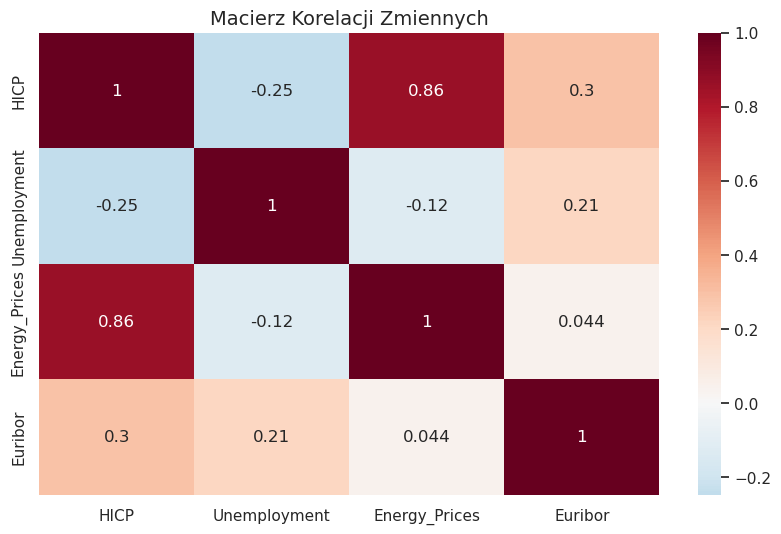

In [3]:
# 1. Definicja zmiennych do pobrania
# Y - Inflacja, X - Zmienne objaśniające
variables = [
    {
        'name': 'HICP', # Inflacja (Y)
        'code': 'prc_hicp_manr',
        'filters': {'geo': 'EE', 'coicop': 'CP00'}
    },
    {
        'name': 'Unemployment', # Bezrobocie (Krzywa Phillipsa)
        'code': 'une_rt_m',
        'filters': {'geo': 'EE', 'age': 'TOTAL', 'sex': 'T', 'unit': 'PC_ACT', 's_adj': 'SA'}
    },
    {
        'name': 'Energy_Prices', # Ceny Energii (Szoki podażowe)
        'code': 'prc_hicp_manr',
        'filters': {'geo': 'EE', 'coicop': 'NRG'}
    },
    {
        'name': 'Euribor', # Stopy procentowe (Koszt pieniądza)
        'code': 'irt_st_m',
        'filters': {'geo': 'EA', 'irt_hndl': 'EURIBOR_3M'}
    }
]

# 2. Pobieranie w pętli
dfs = []
for var in variables:
    df_temp = get_eurostat_series(var['code'], var['filters'], var['name'])
    dfs.append(df_temp)

# 3. Łączenie (Merge) i Czyszczenie
df_full = dfs[0].join(dfs[1:], how='left')

# Oczyszczanie ostateczne
df_full = df_full[df_full.index >= '2000-01-01'] # Analizujemy od 2000 roku
df_full = df_full.groupby(df_full.index).mean()  # Usuwanie duplikatów
df_full = df_full.asfreq('MS').ffill()           # Ciągłość miesięczna

print("\n🏆 BAZA DANYCH GOTOWA:")
print(df_full.tail())

# Zapis na dysk (dla bezpieczeństwa)
os.makedirs('../data/processed', exist_ok=True)
df_full.to_csv('../data/processed/estonia_modeling_data.csv')

# Wykres korelacji
plt.figure(figsize=(10, 6))
sns.heatmap(df_full.corr(), annot=True, cmap='RdBu_r', center=0)
plt.title("Macierz Korelacji Zmiennych")
plt.show()

In [4]:
df_model = df_full.copy()

# Tworzenie zmiennych opóźnionych (Lags t-1)
# Model ADL: Y(t) zależy od Y(t-1) i X(t-1)
df_model['HICP_lag1'] = df_model['HICP'].shift(1)
df_model['HICP_lag2'] = df_model['HICP'].shift(2)
df_model['Unemployment_lag1'] = df_model['Unemployment'].shift(1)
df_model['Energy_lag1'] = df_model['Energy_Prices'].shift(1)
df_model['Euribor_lag1'] = df_model['Euribor'].shift(1)

# Usuwamy NaN powstałe przez shift
df_model = df_model.dropna()

# Podział Train / Test (ostatnie 24 miesiące na test)
test_months = 24
train = df_model.iloc[:-test_months]
test = df_model.iloc[-test_months:]

print(f"📉 Zbiór treningowy: {len(train)} obs. ({train.index.min().date()} - {train.index.max().date()})")
print(f"🔮 Zbiór testowy:    {len(test)} obs. ({test.index.min().date()} - {test.index.max().date()})")

📉 Zbiór treningowy: 286 obs. (2000-03-01 - 2023-12-01)
🔮 Zbiór testowy:    24 obs. (2024-01-01 - 2025-12-01)


In [5]:
# Definicja zmiennych
target = 'HICP'
features = ['HICP_lag1', 'HICP_lag2', 'Unemployment_lag1', 'Energy_lag1', 'Euribor_lag1']

# Przygotowanie macierzy X i Y
Y_train = train[target]
X_train = sm.add_constant(train[features]) # Dodajemy stałą (intercept)

# Dopasowanie modelu
model = sm.OLS(Y_train, X_train).fit()

# Wyniki
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   HICP   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2019.
Date:                Sun, 11 Jan 2026   Prob (F-statistic):          2.86e-217
Time:                        16:00:57   Log-Likelihood:                -321.79
No. Observations:                 286   AIC:                             655.6
Df Residuals:                     280   BIC:                             677.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3566      0.15

📊 WYNIKI WERYFIKACJI (Ostatnie 2 lata):
   Średni błąd (MAE): 0.65 p.p.
   Błąd RMSE:         0.77 p.p.


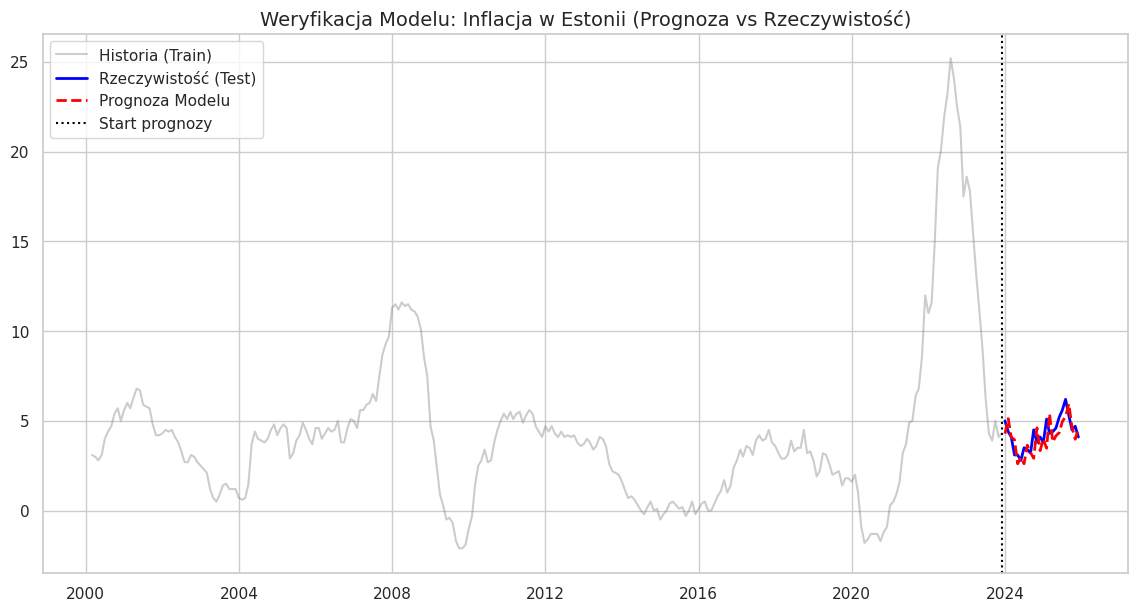

In [6]:
# Przygotowanie danych testowych
X_test = sm.add_constant(test[features], has_constant='add')

# Prognoza Ex-post
predictions = model.predict(X_test)

# Metryki błędów
mae = mean_absolute_error(test[target], predictions)
rmse = np.sqrt(mean_squared_error(test[target], predictions))

print(f"📊 WYNIKI WERYFIKACJI (Ostatnie 2 lata):")
print(f"   Średni błąd (MAE): {mae:.2f} p.p.")
print(f"   Błąd RMSE:         {rmse:.2f} p.p.")

# Wykres weryfikacyjny
plt.figure(figsize=(14, 7))
plt.plot(train.index, train[target], label='Historia (Train)', color='gray', alpha=0.4)
plt.plot(test.index, test[target], label='Rzeczywistość (Test)', color='blue', linewidth=2)
plt.plot(test.index, predictions, label='Prognoza Modelu', color='red', linestyle='--', linewidth=2)
plt.axvline(x=train.index.max(), color='black', linestyle=':', label='Start prognozy')
plt.title('Weryfikacja Modelu: Inflacja w Estonii (Prognoza vs Rzeczywistość)')
plt.legend()
plt.show()

In [ ]:
# ---------------- KONFIGURACJA PROGNOZY (FIXED FOR LAG2) ----------------
future_months = 24
last_date = df_model.index.max()
print(f"📡 Ostatnia znana data w danych: {last_date.date()}")

future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=future_months, freq='MS')

# ---------------- SYMULACJA SCENARIUSZOWA ----------------

# Pobieramy ostatni znany wiersz (t)
last_row = df_model.iloc[-1].copy()
# Pobieramy przedostatni wiersz (t-1) - potrzebny do startu HICP_lag2
second_last_row = df_model.iloc[-2].copy()

forecast_results = []

# Zmienne startowe do "karmienia" pętli
current_lag1 = last_row['HICP']       # Ostatnia znana inflacja
current_lag2 = second_last_row['HICP'] # Przedostatnia znana inflacja

print("🔄 Obliczam prognozę (Model AR2)...")

for date in future_dates:
    # 1. Budujemy wiersz cech
    features_dict = {
        'const': 1.0,
        'HICP_lag1': current_lag1,    # t-1
        'HICP_lag2': current_lag2,    # t-2 (NOWOŚĆ)
        'Unemployment_lag1': last_row['Unemployment'], # Zakładamy stałe
        'Energy_lag1': last_row['Energy_Prices'],      # Zakładamy stałe
        'Euribor_lag1': last_row['Euribor']            # Zakładamy stałe
    }
    
    # 2. Predykcja
    # Pobieramy kolumny w dobrej kolejności (takiej jak w modelu)
    X_future = [features_dict[col] for col in model.params.index]
    predicted_hicp = model.predict([X_future])[0]
    
    # 3. Zapis wyniku
    forecast_results.append({'date': date, 'Forecast': predicted_hicp})
    
    # 4. Aktualizacja zmiennych (Przesuwamy okno w czasie)
    # To co było "miesiąc temu", staje się "dwa miesiące temu"
    current_lag2 = current_lag1
    # Nowa prognoza staje się "miesiąc temu"
    current_lag1 = predicted_hicp

# Wyniki i Wykres
df_forecast = pd.DataFrame(forecast_results).set_index('date')

plt.figure(figsize=(16, 8))
plt.plot(df_model.index, df_model['HICP'], label='Historia', color='black', alpha=0.6)
plt.plot(test.index, predictions, label='Weryfikacja (Test)', color='green', linestyle='--')
plt.plot(df_forecast.index, df_forecast['Forecast'], label='PROGNOZA 2026-2027', color='red', linewidth=3, marker='o')

# Zakładamy, że RMSE jest zdefiniowane wcześniej, jeśli nie - usuń fill_between
try:
    plt.fill_between(df_forecast.index, df_forecast['Forecast'] - rmse, df_forecast['Forecast'] + rmse, color='red', alpha=0.1)
except:
    pass

plt.title(f'Prognoza Inflacji HICP (Model AR2 z korektą autokorelacji)')
plt.ylabel('Inflacja % (r/r)')
plt.legend()
plt.grid(True)

# Zapis wykresu (żebyś miał do README)
plt.savefig('../forecast_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("Ostatnie 5 miesięcy prognozy:")
print(df_forecast.tail())

🔄 Generowanie prognozy na lata 2025-2027...


KeyError: 'HICP_lag2'